In [70]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px


def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT price_numeric, 
                         brand_title, 
                         size_title, 
                         user_id,
                         product_id,
                         catalog_id,
                         status
                    FROM public.tracking_staging
                    WHERE brand_title IN (
                    SELECT brand_title
                         FROM public.tracking_staging 
                         WHERE date >= CURRENT_DATE - INTERVAL '7 DAY'
                         GROUP BY price_numeric, brand_title
                         HAVING COUNT(DISTINCT(product_id)) > 30
                    )
                    LIMIT 10000;
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data.head(10)

,price_numeric,brand_title,size_title,user_id,product_id,catalog_id,status
0,5,Kiabi,12 anos / 152 cm,63431974,2241076688,1697,Muito bom
1,5,Kiabi,12 anos / 152 cm,63431974,2195858671,1672,Muito bom
2,390,Nike,"44,5",54002758,4102685069,1242,Novo com etiquetas
3,1,H&M,S / 36 / 8,94431266,4094715812,197,Bom
4,20,,,185229307,4043831239,2351,Muito bom
5,20,,,185229307,4043823866,2358,Bom
6,25,,,185229307,4043799361,2346,Muito bom
7,100,,,185229307,4043764352,2362,Bom
8,10,,,185229307,4043715452,2343,Muito bom
9,100,,,185229307,4043702370,2358,Muito bom


In [71]:
# Define dropdown widget for brand selection
brand_dropdown = widgets.Dropdown(options=data["brand_title"].unique(), 
                                  description='Select the brand:')

# Define function to update metrics based on selected brand
def update_metrics(change):
    selected_brand = change.new
    filtered_data = data[data['brand_title'] == selected_brand]
    
    products = filtered_data['product_id'].nunique()
    median_price = "{:.2f} €".format(filtered_data['price_numeric'].median())
    std_dev = "{:.2f} €".format(filtered_data['price_numeric'].std())
    total_volume = "{:.2f} €".format(filtered_data['price_numeric'].sum())
    
    products_widget.value = products
    median_price_widget.value = median_price
    std_dev_widget.value = std_dev
    total_volume_widget.value = total_volume

# Attach observer to brand dropdown
brand_dropdown.observe(update_metrics, names='value')

products_widget = widgets.IntText(description='Products:', disabled=True)
active_users_widget = widgets.IntText(description='Active Users:', disabled=True)
median_price_widget = widgets.Text(description='Median Price:', disabled=True)
std_dev_widget = widgets.Text(description='Standard Dev.:', disabled=True)
total_volume_widget = widgets.Text(description='Total Volume:', disabled=True)

# Arrange widgets in a grid layout
grid = widgets.GridspecLayout(6, 1, width='100%')
grid[0, 0] = products_widget
grid[1, 0] = median_price_widget
grid[2, 0] = std_dev_widget
grid[3, 0] = total_volume_widget

# Display widgets
display(brand_dropdown)
display(grid)

Dropdown(description='Select the brand:', options=('Kiabi', 'Nike', 'H&M', '', 'Camaïeu', 'Ravensburger', 'Pri…

GridspecLayout(children=(IntText(value=0, description='Products:', disabled=True, layout=Layout(grid_area='wid…

In [72]:
print(data["price_numeric"].skew())

# preprocessing for visualization purposes
q_high = data["price_numeric"].quantile(0.95)
q_low = data["price_numeric"].quantile(0.01)
data = data[(data["price_numeric"] < q_high) & 
            (data["price_numeric"] > q_low)]

8.982185754190313


In [73]:
fig = px.histogram(data, 
                x="price_numeric", 
                marginal="box", 
                barmode= "overlay", 
                facet_col="status",
                category_orders={"status":["Satisfatório", "Bom", "Muito bom", "Novo sem etiquetas", "Novo com etiquetas"]})

fig

Kruskal-Wallis Test: non-parametric alternative to ANOVA. It compares the medians of three or more groups to determine if there are significant differences.

The dataset doesn't fit ANOVA criteria, so let's go with a non parametric test to assess distributions between status. Because there are 3 or more groups, it's more suitable than Kolmogorov-Smirnov Test.

In [74]:
from scipy.stats import kruskal

# Separate data by status groups
status_groups = [data[data['status'] == status]['price_numeric'] for status in data['status'].unique()]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*status_groups)

# Print results
print("Kruskal-Wallis Test:")
print(f"Statistic: {statistic}, p-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis: distributions are different (p_value < alfa)")
else:
    print("Fail to reject null hypothesis: distributions are similar")

Kruskal-Wallis Test:
Statistic: 403.0747917522124, p-value: 6.0245733396409355e-86
Reject null hypothesis: distributions are different (p_value < alfa)


 Tukey's HSD (Honestly Significant Difference)

 When conducting a Tukey HSD test, we compare all possible pairs of group means to determine whether any pair differs significantly. **If the test results in a rejection of the null hypothesis for a particular pair of groups, it indicates that there is a statistically significant difference between the means of those groups**.

 $H0​: μ_1=μ_2=μ_3=…=μk​$

 Overall, the Tukey HSD test helps identify which specific group means are different from each other after conducting an ANOVA test. (Tukeys is usually a completary test - adhoc)

In [75]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#manova = MANOVA(endog=data[["brand_title", "status", "size_title", "catalog_id"]], 
#                exog=data["price"].astype(float))
#print(manova.mv_test())

#topbrands = data['brand_title'].value_counts().nlargest(30)
#filter = topbrands.index.tolist() 
#data = data[data['brand_title'].isin(filter)]

tukey_result = pairwise_tukeyhsd(endog=data['price_numeric'], 
                                 groups=data['status'], 
                                 alpha=0.05)
print(tukey_result.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
               Bom          Muito bom   0.7637 0.0008  0.2341  1.2933   True
               Bom Novo com etiquetas   5.2515    0.0  4.3254  6.1776   True
               Bom Novo sem etiquetas   2.2213    0.0  1.5841  2.8584   True
               Bom       Satisfatório  -1.1285 0.1723 -2.5156  0.2585  False
         Muito bom Novo com etiquetas   4.4878    0.0  3.6459  5.3298   True
         Muito bom Novo sem etiquetas   1.4576    0.0  0.9504  1.9647   True
         Muito bom       Satisfatório  -1.8922  0.001 -3.2245 -0.5599   True
Novo com etiquetas Novo sem etiquetas  -3.0303    0.0 -3.9437 -2.1168   True
Novo com etiquetas       Satisfatório    -6.38    0.0 -7.9138 -4.8463   True
Novo sem etiquetas       Satisfatório  -3.3498    0.0 -4.7284 -1.9712   True

- Reject: whether to reject null hypothesis. True, we reject null hypothesis, meaning the diff in the group means are different.
- meandiff: The mean difference between the two groups.
- p-adj: The adjusted p-value after correcting for multiple comparisons.
- lower and upper: The lower and upper bounds of the confidence interval for the mean difference.

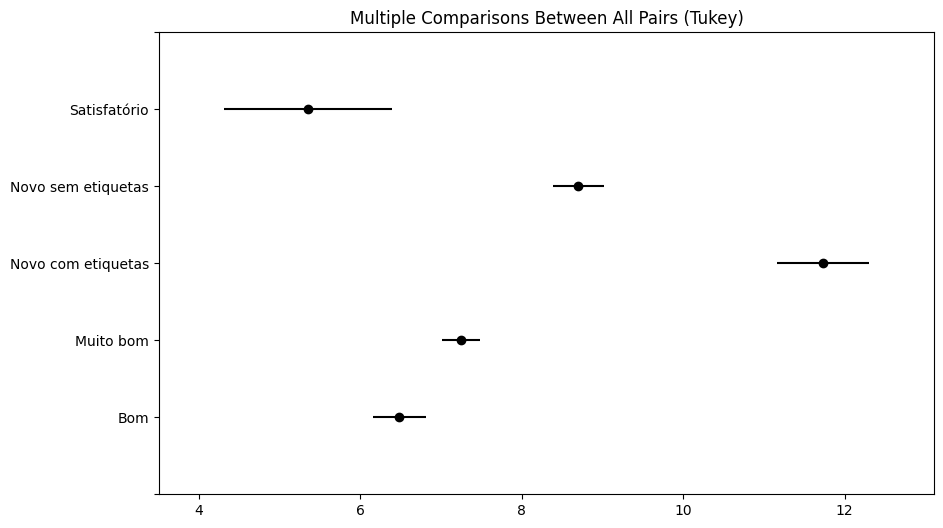

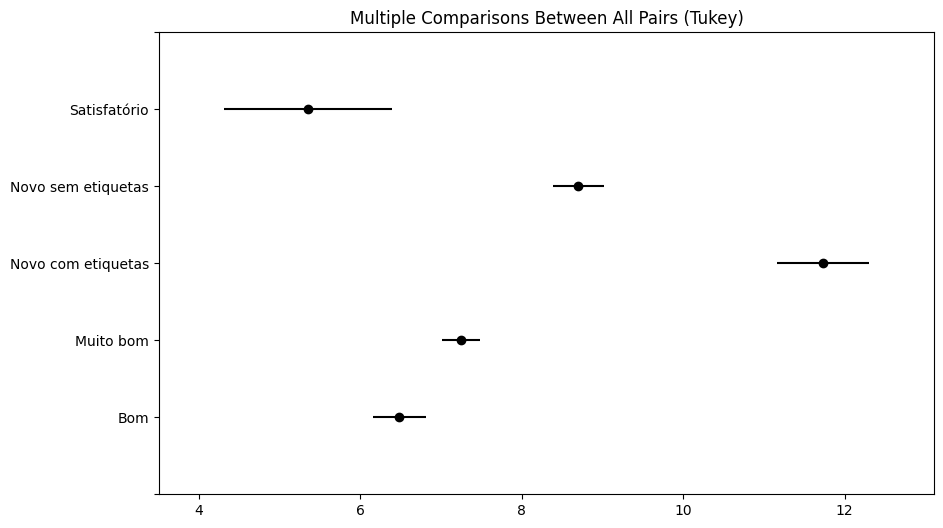

In [76]:
tukey_result.plot_simultaneous()